In [1]:
%matplotlib inline
# %load_ext autoreload
# %autoreload 1
from stack_nlp import *
from jupyter_mplsettings import *
matplotlib.rc('font', **font)

In [2]:
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

In [3]:
cfg = local_import("./laptop.py")

In [4]:
PrepareData(cfg)

Shape of question df (1696819, 21)
Shape of answer df (2028240, 21)
Loading word dictionary...
Shape of dictionary (3048821, 4)
Warning! Dropping some words from word list, please verify!
Dropping 1211
Shape of merged df (1000000, 33)
Selecting only questions with at least 5 meaningful words.
This removes 8582 questions.
Removing bad values with missing feature information.
This affects 19 questions.
Calculating normalized columns. They are available under usual column name + _norm.


In [5]:
data = cfg.data

In [6]:
data.keys()

['meta', 'dict', 'features', 'answers']

In [7]:
qs = data["meta"];

In [8]:
qs.head()
print qs.shape

(991399, 52)


In [11]:
print np.sum(~qs.dt_answer.isnull())
print np.sum(~qs.dt_accanswer.isnull())

706703
386998


In [13]:
qs.columns
cols_desc

{'AnswerCount': 'Number of replies',
 'BodyNCodes': 'Number of code tags',
 'BodyNQMarks': 'Number of question marks',
 'BodySize': 'Length of post text',
 'Score': 'Question score',
 'nwords': 'Number of meaningful words',
 'ordermean': 'Word prevalence (average)',
 'orderstd': 'Word prevalence (std)',
 'ordersum': 'Word prevalence (sum)',
 'prob_bern': 'Joined bernoulli probability of words',
 'ratio': 'Ratio of number of verbs to nouns',
 'titlelen': 'Length of title'}

In [125]:
n_timecat = 6
timecat_bins = np.linspace(-0.5, n_timecat + 0.5, n_timecat + 2)

qs["dayhour"] = qs.CreationDate.dt.hour
qs["weekday"] = qs.CreationDate.dt.dayofweek
qs["day"] = qs.CreationDate.dt.dayofyear
# training and testing samples
qs = shuffle(qs)
print "Length of the whole shuffled question df:", len(qs)
# limiting to questions with accepted answer for training

tmask = np.isfinite(qs.dt_accanswer_hour)
time_categories = mquantiles(qs.loc[tmask].dt_accanswer_hour, prob=np.linspace(0, 1, n_timecat + 1))
print "Bins for time categories", time_categories
qs["timecat"] = 0
qs.loc[tmask, "timecat"] = np.digitize(qs.loc[tmask].dt_accanswer_hour, time_categories) - 1
qs.loc[~tmask, "timecat"] = n_timecat

qssel = qs[tmask]
qssel = qssel.append(qs[~tmask].iloc[:int(len(qssel) * 1. / (len(time_categories) - 1))])
qssel = shuffle(qssel)

train = 350000
qstrain = qssel.iloc[:train]
qstest = qssel.iloc[train:]
print "Length of the training set:", len(qstrain)
print "Length of the testing set:", len(qstest)

# label = "dt_accanswer_hour"
label = "timecat"

# sample with no answers, aka the ultimate testing sample
qsnone = qs[qs.AnswerCount == 0]
print "Number of questions without answer:", len(qsnone)

Length of the whole shuffled question df: 991399
Bins for time categories [  0.00000000e+00   1.23864000e-01   2.84184000e-01   6.78036000e-01
   2.24010240e+00   1.74328752e+01   5.47461192e+03]
Length of the training set: 350000
Length of the testing set: 101497
Number of questions without answer: 284672


In [140]:
time_categories

array([  0.00000000e+00,   1.23864000e-01,   2.84184000e-01,
         6.78036000e-01,   2.24010240e+00,   1.74328752e+01,
         5.47461192e+03])

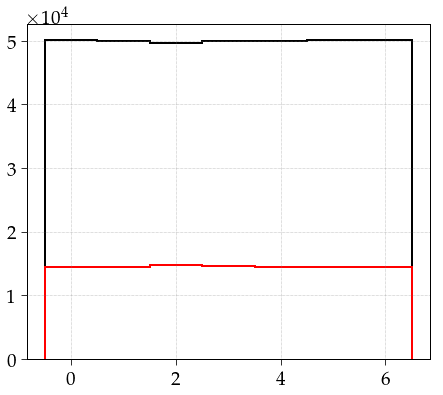

In [126]:
plt.figure(figsize=(8, 6))
qstrain.timecat.hist(color="k", lw=2, histtype="step", bins=timecat_bins)
qstest.timecat.hist(color="red", lw=2, histtype="step", bins=timecat_bins)

In [127]:
qstrain.columns

Index([u'AcceptedAnswerId', u'AnswerCount', u'BodyNCodes', u'BodyNQMarks',
       u'BodySize', u'ClosedDate', u'CommentCount', u'CommunityOwnedDate',
       u'CreationDate', u'FavoriteCount', u'Id', u'LastActivityDate',
       u'LastEditDate', u'LastEditorUserId', u'OwnerUserId', u'ParentId',
       u'PostTypeId', u'Score', u'Tags', u'Title', u'ViewCount', u'titlelen',
       u'hasAnswers', u'dt_created', u'Id_r', u'hot_indices', u'nwords',
       u'ordermean', u'orderstd', u'ordersum', u'prob_bern', u'prob_poiss',
       u'ratio', u'ParentId_first', u'CreationDate_first', u'Id_acc',
       u'CreationDate_acc', u'dayhour', u'weekday', u'dt_answer',
       u'dt_accanswer', u'dt_answer_hour', u'dt_accanswer_hour',
       u'BodyNCodes_norm', u'BodyNQMarks_norm', u'BodySize_norm',
       u'titlelen_norm', u'nwords_norm', u'ordersum_norm', u'ordermean_norm',
       u'orderstd_norm', u'ratio_norm', u'day', u'timecat'],
      dtype='object')

## Fitting random forest to the space of simple features derived from the text

In [128]:
cols = ["BodyNCodes", "BodyNQMarks", "BodySize", "titlelen", "nwords", "ordersum", "ordermean", "orderstd", "ratio"]

In [158]:
pipe_time_fct = lambda a: Pipeline([
         ("cst", ColumnSelectTransformer(["weekday", "dayhour"])),
         ("onehot", OneHotEncoder(sparse=True)),
         ("ranforest", RandomForestClassifier(n_estimators=15))
    ])

pipe_time = pipe_time_fct(2)

In [159]:
pipe_time.fit(qstrain, qstrain[label])
pred = pipe_time.predict(qstest)
print np.column_stack((pred, qstest[label]))
print pipe_time.score(qstest, qstest[label])

[[5 4]
 [0 0]
 [0 6]
 ..., 
 [0 5]
 [4 6]
 [4 6]]
0.16050720711


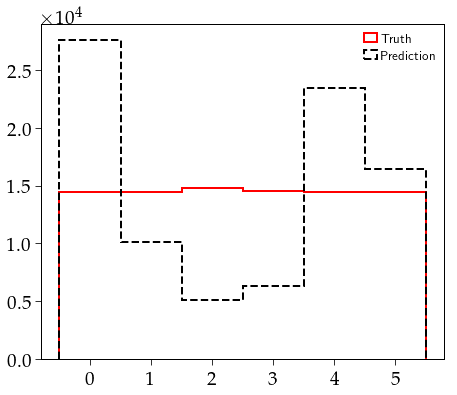

In [160]:
plt.figure(figsize=(8, 6))
plt.hist(qstest[label], color="r", ls="-", lw=2, histtype="step", bins=np.linspace(-0.5, 5.5, 7), label="Truth")
plt.hist(pred, color="k", ls="--", lw=2, histtype="step", bins=np.linspace(-0.5, 5.5, 7), label="Prediction")
plt.legend(loc="upper right");

In [161]:
relcols = ["BodyNCodes", "BodyNQMarks", "BodySize", "titlelen", "nwords", "ordersum", "ordermean", "orderstd", "ratio"]
cols = [col + "_norm" for col in relcols]
print cols

pipe_feat_fct = lambda a: Pipeline([
         ("cst", ColumnSelectTransformer(cols)),
#          ("poly", PolynomialFeatures(degree=2)),
         ("ranforest", RandomForestClassifier(n_estimators=15))
#          ("multi", MultiModelRegressor(Ridge(alpha=a, normalize=False), RandomForestRegressor(n_estimators=15)))
#          ("multi", MultiModelRegressor(SGDRegressor(), RandomForestRegressor(n_estimators=20)))
    ])

pipe_feat = pipe_feat_fct(2)

['BodyNCodes_norm', 'BodyNQMarks_norm', 'BodySize_norm', 'titlelen_norm', 'nwords_norm', 'ordersum_norm', 'ordermean_norm', 'orderstd_norm', 'ratio_norm']


In [23]:
cv = model_selection.ShuffleSplit(n_splits=20, test_size=0.2, random_state=42)
def compute_error(est, X, y):
    return -model_selection.cross_val_score(est, X, y, cv=cv, scoring='neg_mean_squared_error').mean()

In [ ]:
for alpha in np.linspace(0.1, 10, 20):
    pipe = pipe_feat_fct(alpha)
    pipe.fit(qstrain, np.log(qstrain[label]))
    print alpha, compute_error(pipe, qstrain, np.log(qstrain[label]))

In [162]:
pipe_feat.fit(qstrain, qstrain[label])
pred = pipe_feat.predict(qstest)
print np.column_stack((pred, qstest[label]))
print pipe_feat.score(qstest, qstest[label])

[[5 4]
 [3 0]
 [4 6]
 ..., 
 [0 5]
 [1 6]
 [5 6]]
0.174103668089


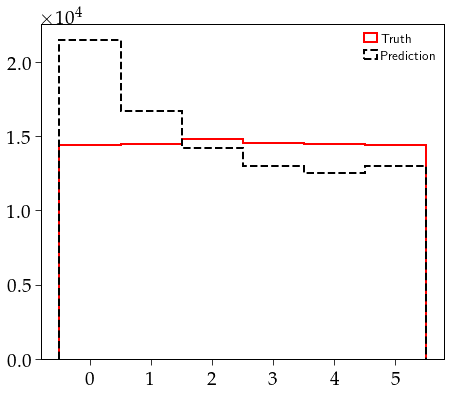

In [163]:
plt.figure(figsize=(8, 6))
plt.hist(qstest[label], color="r", ls="-", lw=2, histtype="step", bins=np.linspace(-0.5, 5.5, 7), label="Truth")
plt.hist(pred, color="k", ls="--", lw=2, histtype="step", bins=np.linspace(-0.5, 5.5, 7), label="Prediction")
plt.legend(loc="upper right");

In [169]:
comp = pd.DataFrame({"truth": qstest[label], "pred": pred})
comp = comp.groupby(["truth", "pred"]).apply(len)
comp = comp.unstack(level=-1)
comp = comp * 1. / comp.groupby("truth").apply(sum, axis=0)
print comp

pred     0    1    2    3    4    5    6
truth                                   
0      1.0  1.0  1.0  1.0  1.0  1.0  1.0
1      1.0  1.0  1.0  1.0  1.0  1.0  1.0
2      1.0  1.0  1.0  1.0  1.0  1.0  1.0
3      1.0  1.0  1.0  1.0  1.0  1.0  1.0
4      1.0  1.0  1.0  1.0  1.0  1.0  1.0
5      1.0  1.0  1.0  1.0  1.0  1.0  1.0
6      1.0  1.0  1.0  1.0  1.0  1.0  1.0


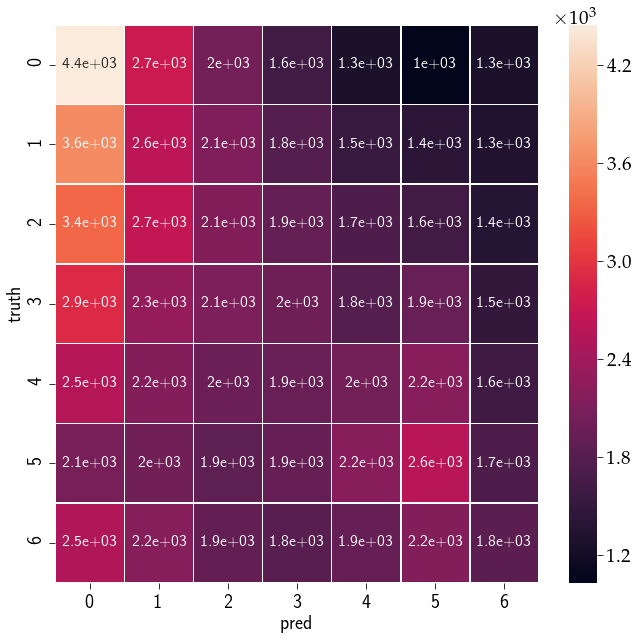

In [165]:
import seaborn as sns
plt.figure(figsize=(12,10))
ax = sns.heatmap(comp, annot=True, linewidths=0.5)

In [44]:
pipe_tags = Pipeline([
                     ("cst", ColumnSelectTransformer(["Tags"])),
                     ("dec", DictEncoder("Tags")),
                     ("dvec", DictVectorizer(sparse=True)),
                     ("tfid", TfidfTransformer()),
                     # ("poly", PolynomialFeatures(degree=2)),  # not working???
#                      ("ridge", Ridge(alpha=2.0))
                     ("multi", MultiModelRegressor(Ridge(alpha=2, normalize=False), RandomForestRegressor(n_estimators=15)))
                     # ("kridge", KernelRidge(alpha=1.))  # runs out of memory quickly while fitting...
                     # ("svr", SVR())
                     ])

In [45]:
pipe_tags.fit(qstrain, np.log(qstrain[label]))
pred = pipe_tags.predict(qstest)
print np.column_stack((pred, np.log(qstest[label])))
print pipe_tags.score(qstest, np.log(qstest[label]))

Performing base regression...
Performing residual regression...
[[ 2.50372863  0.91705204]
 [ 0.68859679  2.96888591]
 [ 1.2938708   1.26329248]
 ..., 
 [-1.59633655 -1.46409159]
 [ 0.39287452 -0.06258204]
 [-1.01475689 -1.76286885]]
0.124504973648


In [18]:
pipe_words = Pipeline([
                      ("cst", ColumnSelectTransformer(["hot_indices"])),
                      ("dec", DictEncoder("hot_indices")),
                      ("dvec", DictVectorizer(sparse=True)),
                      ("tfid", TfidfTransformer()),
#                       ("ridge", Ridge(alpha=2.0))
#                       ("multi", MultiModelRegressor(Ridge(alpha=a, normalize=True), RandomForestRegressor(n_estimators=15)))
#                       ("multi", MultiModelRegressor(Ridge(alpha=2, normalize=True), MLPRegressor(hidden_layer_sizes=(50, 50))))
                      ("mlp", MLPRegressor(hidden_layer_sizes=(100, 100)))
                      ])

In [19]:
pipe_words.fit(qstrain, np.log(qstrain[label]))
pred = pipe_words.predict(qstest)
print np.column_stack((pred, np.log(qstest[label])))
print pipe_words.score(qstest, np.log(qstest[label]))

[[ 0.11661578  1.73275229]
 [-0.68789848  1.62309463]
 [-0.41625747  0.56544562]
 ..., 
 [-0.95755484 -2.74837232]
 [-0.66469107 -2.45769623]
 [-0.03610053 -1.2427968 ]]
0.0427342687598


In [90]:
from sklearn.pipeline import FeatureUnion
union = FeatureUnion([
                     ("tags", EstimatorTransformer(pipe_tags)),
                     ("words", EstimatorTransformer(pipe_words)),
                     ("feat", EstimatorTransformer(pipe_feat))
                     ])

pipe_combined = Pipeline([
                    ("union", union),
                    ("ridge", Ridge(alpha=3.0))
                    # ("comb", CustomCombiner())
                    ])

In [92]:
pipe_combined.fit(qstrain, np.log(qstrain[label]))
pred = pipe_combined.predict(qstest)
print np.column_stack((pred, np.log(qstest[label])))
print pipe_combined.score(qstest, np.log(qstest[label]))

Performing base regression...
Performing residual regression...
Performing base regression...
Performing residual regression...
[[-1.38131283 -1.24080278]
 [ 2.58146676  2.53918837]
 [-1.48334503 -2.46557472]
 ..., 
 [-0.68950884 -2.54889492]
 [ 0.51332501 -1.11581542]
 [ 1.50734924  3.57332448]]
0.461645944995


In [93]:
import dill

In [94]:
dill.dump(pipe_combined, open("pipe_feat.dill", "w"))

In [ ]:
pipe_feat = dill.load(open('pipe_feat.dill', 'r'))

## Investigating difference (residuals) in test sample vs. various dimensions

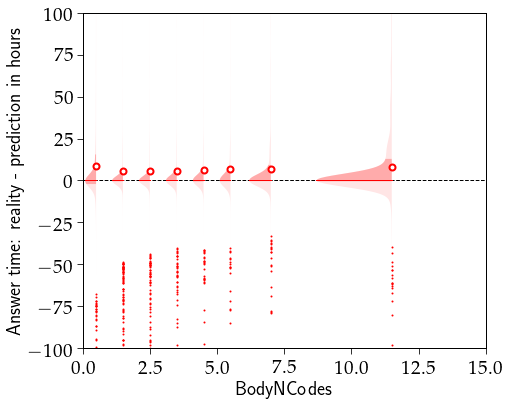

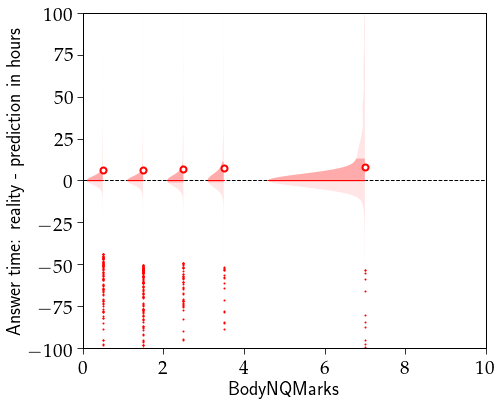

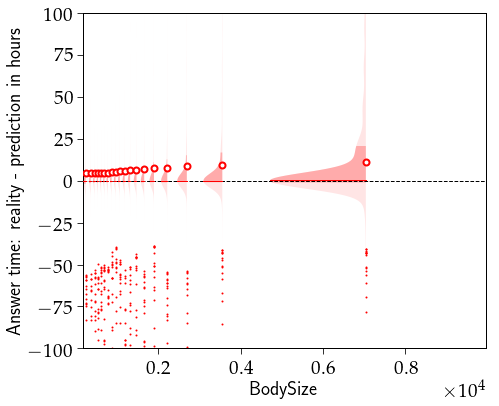

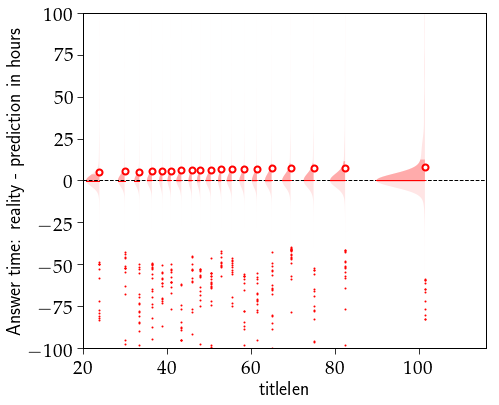

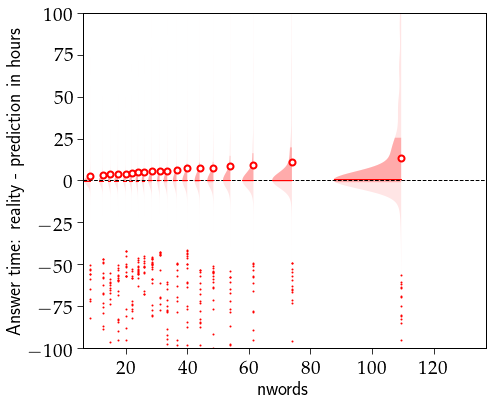

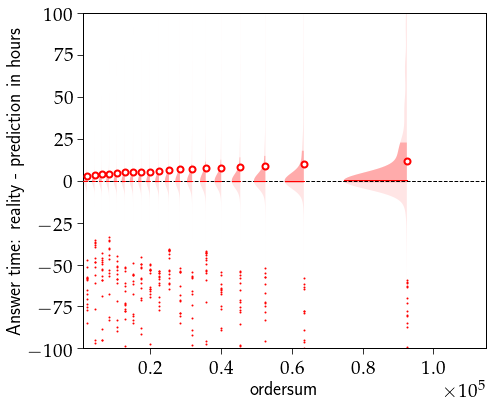

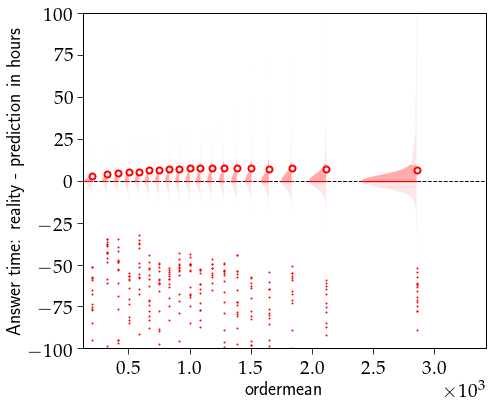

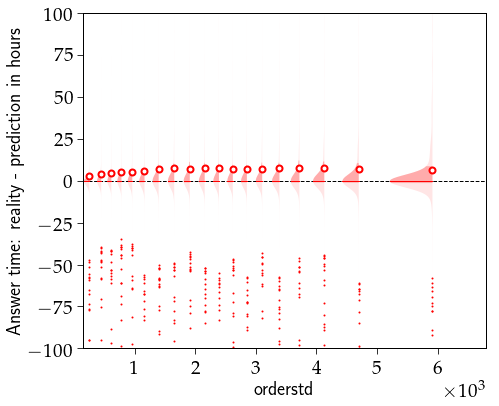

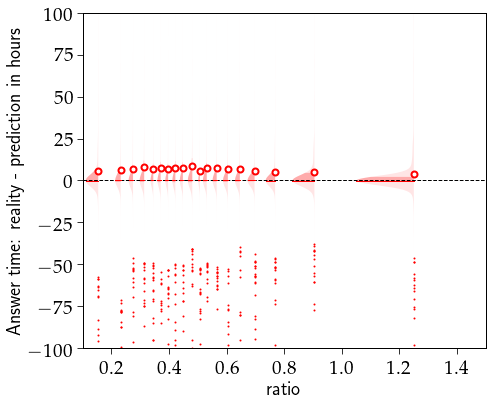

In [47]:
predtimes = np.e ** pred
cols = [col.replace("_norm", "") for col in qstrain.columns if "_norm" in col]
diff = qstest[label] - predtimes

for i, col in enumerate(cols):
    yquants = mquantiles(diff, prob=[0.05, 0.95])
    xquants = mquantiles(qstest[col], prob=np.linspace(0.01, 0.99, 20))
    plt.figure(i, figsize=(8, 6))
    plt.xlabel("%s" % col)
    plt.ylabel(r"Answer time: reality - prediction in hours")
    QuickSlicePlot(qstest[col], diff, qstest.dt_accanswer_hour, zbins=1, yrange=yquants, 
                   xbins=xquants, draw="amv", color="red", ms=6,
                   axes=plt.gca())
    plt.axhline(0, lw=1, ls="--", color="k")
    plt.ylim(-100, 100)
    plt.xlim(min(xquants), max(xquants))
    plt.savefig("./plots/residual_vs_%s.pdf" % col)

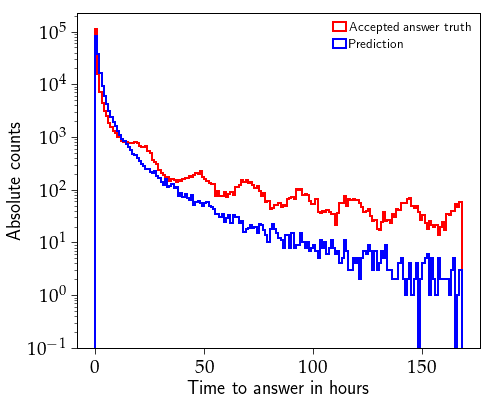

In [67]:
predtimes = np.e ** pred
plt.figure(figsize=(8, 6))
plt.xlabel(r"Time to answer in hours")
plt.ylabel(r"Absolute counts")
plt.hist(qstest.dt_answer_hour, range=[0, 7 * 24], bins=7 * 24, 
         histtype="step", lw=2, color="r", label="Accepted answer truth", log=True);
plt.hist(predtimes, range=[0, 7 * 24], bins=7 * 24,
        histtype="step", ls="-", lw=2, color="b", label="Prediction", log=True);
# plt.semilogy(nonposy="clip")
plt.legend(loc="upper right")
plt.savefig("./plots/dthist_predictions.pdf")

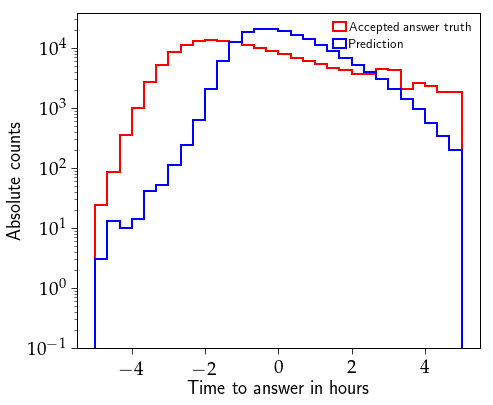

In [68]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Time to answer in hours")
plt.ylabel(r"Absolute counts")
plt.hist(qstest.dt_answer_hour.apply(np.log), range=[-5, 5], bins=30,
         histtype="step", lw=2, color="r", label="Accepted answer truth", log=True);
plt.hist(np.log(predtimes), range=[-5, 5], bins=30,
         histtype="step", ls="-", lw=2, color="b", label="Prediction", log=True);
# plt.semilogy(nonposy="clip")
plt.legend(loc="upper right")
plt.savefig("./plots/dthist_log_predictions.pdf")

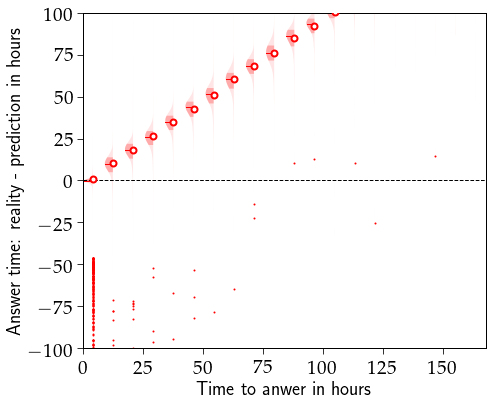

In [50]:
plt.figure(figsize=(8, 6))
plt.xlabel(r"Time to anwer in hours")
plt.ylabel(r"Answer time: reality - prediction in hours")
QuickSlicePlot(qstest.dt_answer_hour, diff, qstest.dt_accanswer_hour, zbins=1, yrange=[-50, 50], 
               xRange=[0, 7 * 24], xbins=20, draw="amv", color="red", ms=6,
               axes=plt.gca())
plt.axhline(0, lw=1, ls="--", color="k")
plt.ylim(-100, 100)
plt.xlim(0, 7 * 24)
plt.savefig("./plots/dtresidual_vs_dt.pdf")

## effect of the number of questions per time (more questions -> more answer delay?)

In [58]:
# number of 
date_edges = pd.date_range(qstrain.CreationDate.min(), qstrain.CreationDate.max(), freq="H")
# print date_edges
date_centers = date_edges[:-1] + (date_edges[1:] - date_edges[:-1]) / 2
date_centers = date_centers.to_pydatetime()
# print date_centers
allcounts = pd.cut(qstrain.CreationDate, bins=date_edges).value_counts().values[::-1]

In [62]:
allcounts.shape
date_edges.shape

(1716,)

In [ ]:
qstrain

In [88]:
print qstrain.shape
# doing it with groupby...more elegant
qrate = qstrain.groupby([qstrain.CreationDate.dt.year, qstrain.CreationDate.dt.month, 
                         qstrain.CreationDate.dt.day, qstrain.CreationDate.dt.hour]).size()

(200000, 46)


In [90]:
qstrainmulti = qstrain.set_index([qstrain.CreationDate.dt.year, qstrain.CreationDate.dt.month, 
                                  qstrain.CreationDate.dt.day, qstrain.CreationDate.dt.hour])
qstrainmulti["qrate"] = qrate
qstrain = qstrainmulti.reset_index(drop=True)
print qstrain.shape

(200000, 47)


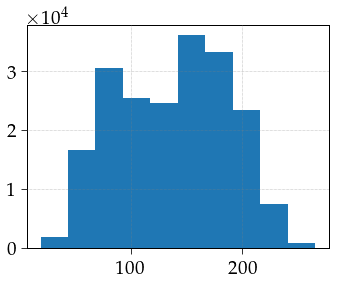

In [96]:
qstrain.qrate.hist()

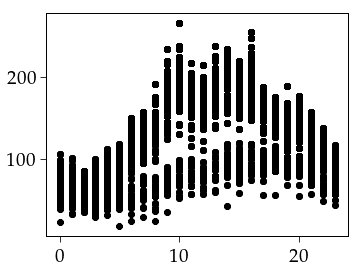

In [98]:
plt.plot(qstrain.CreationDate.dt.hour, qstrain.qrate, "k.")

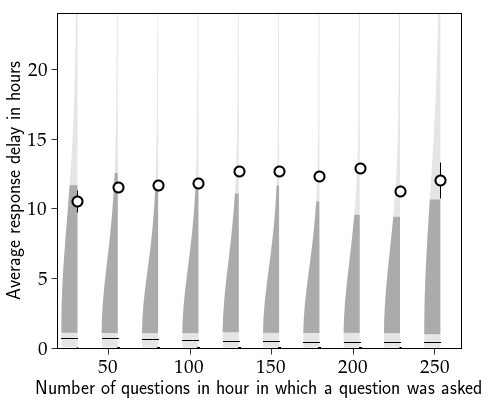

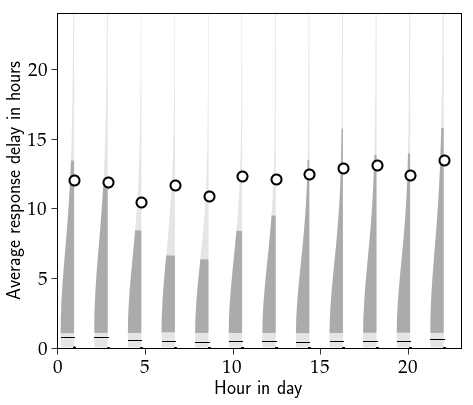

In [99]:
# dependence of average answer delay with the rate of questions in the same hour of asking a particular question
plt.figure(figsize=(8, 6))
plt.xlabel("Number of questions in hour in which a question was asked")
plt.ylabel("Average response delay in hours")
QuickSlicePlot(qstrain.qrate, qstrain.dt_accanswer_hour, qstrain.Score, zbins=1, xbins=10,
              yrange=[0, 24], draw="amv", axes=plt.gca())
plt.show()

# dependence of average answer delay with the rate of questions in the same hour of asking a particular question
plt.figure(figsize=(8, 6))
plt.xlabel("Hour in day")
plt.ylabel("Average response delay in hours")
QuickSlicePlot(qstrain.CreationDate.dt.hour, qstrain.dt_accanswer_hour, qstrain.Score, zbins=1, xbins=12,
              yrange=[0, 24], draw="amv", axes=plt.gca())
plt.show()